Aim: forecast demand for bikeshare stations 
  - datetime: a timestamp collected hourly.
  - season: a categorical column that lists the current season for that observation
  - holiday: a column (0 or 1), that detects whether or not it was a holiday
  - workingday: a column (0 or 1), that encodes whether or not it was a workday or not
  - weather: a categorical column that lists a light weather description for the observation
  - temp: the temperature outside
  - atemp: the temperature it feels like outside
  - humidity: the humidity outside
  - windspeed: the windspeed, in mph
  - count: the number of bikes checked out during that hour

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.model_selection import cross_val_score
from pdpbox import pdp, info_plots

In [2]:
#read the file
df = pd.read_csv('../data/bikeshare.csv', parse_dates = ['datetime'],index_col = 'datetime')

In [3]:
# using shift require datetime index!
df['HoH'] = df['count'] - df['count'].shift(1)
df['DoD'] = df['count'] - df['count'].shift(24)
df['MoM'] = df['count'] - df['count'].shift(456)  #720 would be a full month 24h x 30 days but we have only the first 19 days of the month
one_year = pd.DateOffset(years=1)
df['YoY'] = df['count'] - df['count'].shift(1, freq=one_year)

In [4]:
#using dt require datetime column
df['datetime2'] = df.index
df['month'] = df.datetime2.dt.month
df['year'] = df.datetime2.dt.year
df['hour'] = df.datetime2.dt.hour
df['day'] = df.datetime2.dt.day
df['dayofweek'] = df.datetime2.dt.dayofweek

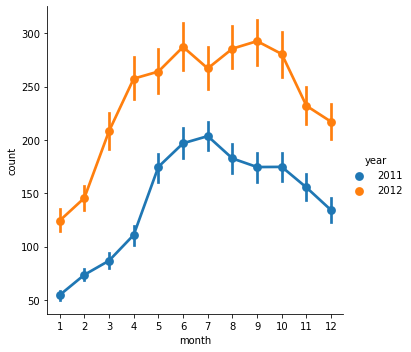

In [5]:
sns.catplot(x='month', y='count', kind='point', hue='year', data=df)

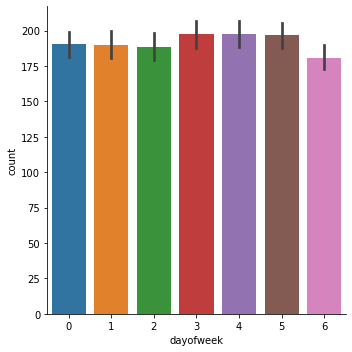

In [6]:
sns.catplot(x='dayofweek', y='count', kind='bar', data=df)

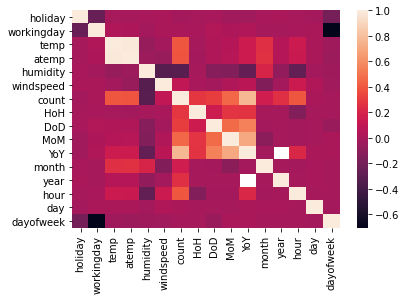

In [7]:
sns.heatmap(df.corr())

In [8]:
# humidity & count not corr -> interesting fact

# holiday & workingday not corr => data missing or not correct
df['holiday'].corr(df['workingday'])

-0.25049139118730124

In [9]:
#solve the missing data
missing_cols = df.loc[:, df.isnull().sum() > 0].select_dtypes(include=np.number).columns.tolist()
df[missing_cols] = df[missing_cols].fillna(0)

In [10]:
# create the pipe
pipe = make_pipeline(ce.OrdinalEncoder(), GradientBoostingRegressor())

In [11]:
#define X and y
X = df.drop('count', axis=1)
y = df['count']

In [12]:
# weekend & holiday vs. working day?
X['weekend_or_holiday'] = np.where((X['dayofweek'] == 5 ) | (X['dayofweek'] == 6) | X['holiday'] ==1, True, False)

In [13]:
# passage of time
X['time_pass'] = (X['datetime2'] - X['datetime2'].min()).dt.days

In [14]:
# peak hour?
X['peak_hour'] = np.where(((X['hour'] > 7) & (X['hour'] < 9)) | ((X['hour'] > 16) & (X['hour'] < 18)), True, False)

In [15]:
#daylight?
for s in X['season']:
    if s == 'Spring':
        X['daylight'] = np.where((X['hour'] > 7) & (X['hour'] < 19), True, False)
    elif s == 'Summer':
        X['daylight'] = np.where((X['hour'] > 5) & (X['hour'] < 21), True, False)
    elif s == 'Fall':
        X['daylight'] = np.where((X['hour'] > 9) & (X['hour'] < 18), True, False)
    elif s == 'Winter':
        X['daylight'] = np.where((X['hour'] > 11) & (X['hour'] < 16), True, False)

In [16]:
X.drop(['datetime2'],axis=1, inplace = True)

In [17]:
#split in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [18]:
#getting the validation data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

In [19]:
#fit the model
pipe.fit(X_train,y_train).score(X_val,y_val)

0.8734632869252204

In [20]:
#feature importance
feat_importance = pd.DataFrame({
    'feature':X.columns,
    'importance' : pipe.steps[1][1].feature_importances_
})
feat_importance.set_index('feature').sort_values(by='importance', ascending = False)

,importance
feature,
MoM,0.461068
hour,0.246713
HoH,0.092682
time_pass,0.055932
YoY,0.043714
atemp,0.032474
DoD,0.025237
temp,0.015433
month,0.010628


In [21]:
max_depth = [4, 5]
learning_rate = [.01, .1]
num_trees = [500, 1000]
cv_scores = []

for depth in max_depth:
    for rate in learning_rate:
        for tree in num_trees:
            print(f"Testing model with: depth: {depth}, rate: {rate}, trees: {tree}")
            pipe.steps[1][1].set_params(max_depth=depth, learning_rate=rate, n_estimators=tree)
            scores = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=7)
            cv_scores.append((scores.mean(), depth, rate, tree))

Testing model with: depth: 4, rate: 0.01, trees: 500
Testing model with: depth: 4, rate: 0.01, trees: 1000
Testing model with: depth: 4, rate: 0.1, trees: 500
Testing model with: depth: 4, rate: 0.1, trees: 1000
Testing model with: depth: 5, rate: 0.01, trees: 500
Testing model with: depth: 5, rate: 0.01, trees: 1000
Testing model with: depth: 5, rate: 0.1, trees: 500
Testing model with: depth: 5, rate: 0.1, trees: 1000


In [22]:
max(cv_scores)

(0.9232060550101, 4, 0.1, 1000)

In [23]:
pipe.steps[1][1].set_params(max_depth=4, learning_rate=0.1, n_estimators=500)

GradientBoostingRegressor(max_depth=4, n_estimators=500)

In [24]:
pipe.fit(X_train,y_train).score(X_val,y_val)

0.8836791862239491

In [25]:
cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=10)

array([0.88888335, 0.90825719, 0.93929092, 0.94470119, 0.95591252,
       0.94137635, 0.93309223, 0.92414307, 0.96304922, 0.88602715])

In [26]:
pipe.score(X_test,y_test)

0.8786800091743279

In [59]:
pipe.predict(X_test)

array([ 15.73621822,   3.78432657,  34.59934492, ..., 138.93292043,
       119.12939259,  86.44176679])

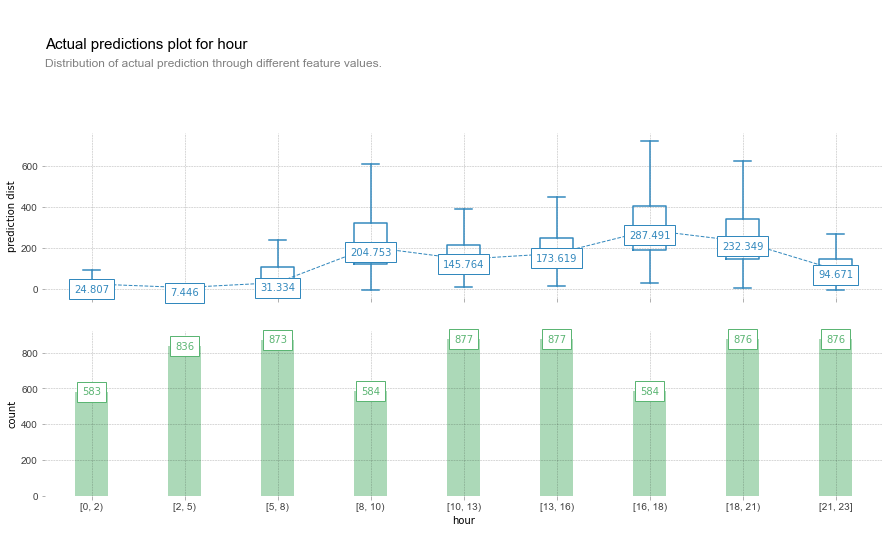

In [61]:
# TARGET PLOT -- what was the impact of the hour on the number of bikes checked out?
fig, axes, summary_df = info_plots.actual_plot(
    model=pipe, X=X_train, 
    feature='hour', feature_name='hour', predict_kwds={}
)

#conclusion: it shows the correct hourly trend but the numbers are not very useful:
#                - green = freq, how many times there is 7 o'clock? not insigtful
#                - blue = ave regardless of the month; the numbers show average all 12 months
#                                        (there is difference between a summer and winter month)
#                                                                     


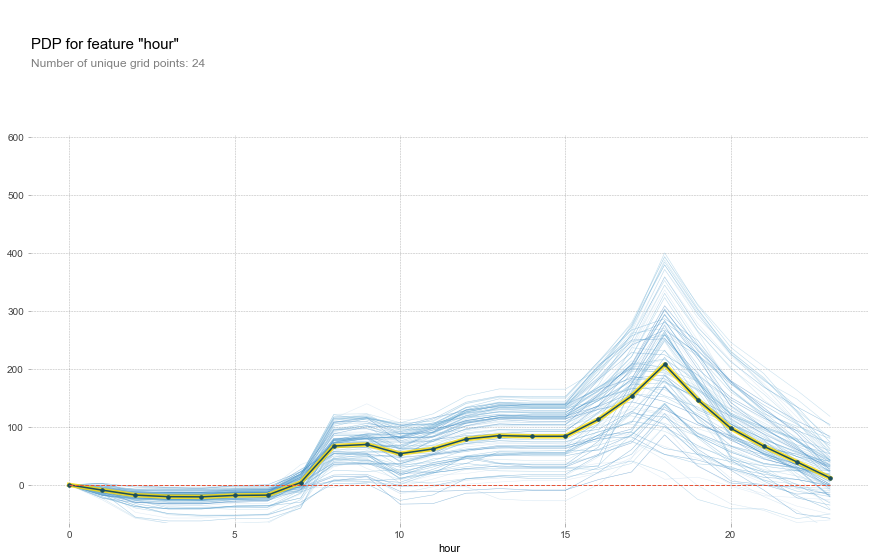

In [65]:
# what was the additive impact of EACH unique value of xxx?  What was its marginal impact?
pdp_marginal_impact = pdp.pdp_isolate(
    model=pipe, dataset=X_train, model_features=X.columns.tolist(), 
    feature='hour', cust_grid_points=X_train['hour'].unique().tolist()
)
fig, axes = pdp.pdp_plot(pdp_marginal_impact, 'hour', plot_lines=True, frac_to_plot=100)

# conclusion: there is an increase in demand for bikes during the peak hours: 7am to 8 am  and 3pm to 6pm
#                (The light blue lines are meaningless because we can not influence the passage of time)

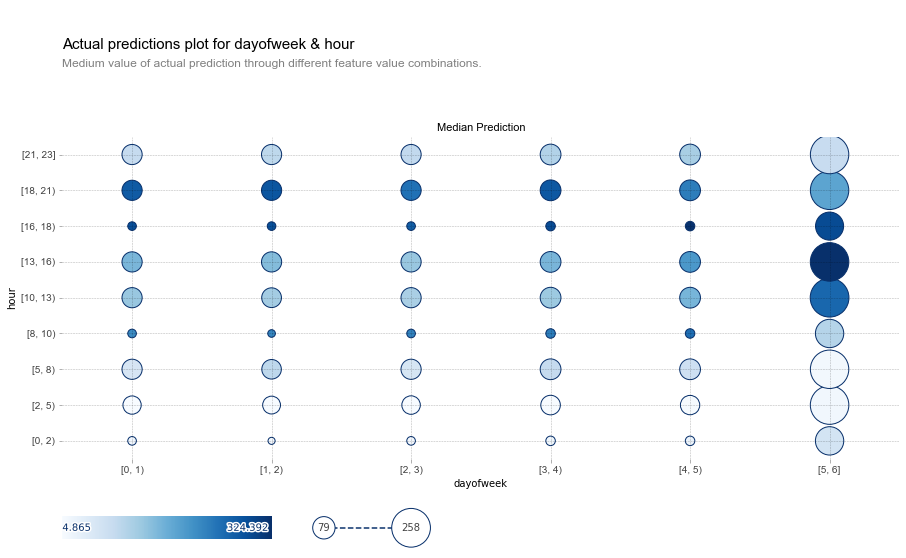

In [66]:
# interactions1
fig, axes, summary_df = info_plots.actual_plot_interact(
    model=pipe, X=X_train, 
    features=['dayofweek', 'hour'], 
    feature_names=['dayofweek', 'hour']
)

#conclusion: hourly pattern during the working week is similar (2 peaks: morning and evening) 
#            and different pattern during the weekend (only one peak during 13-16h)

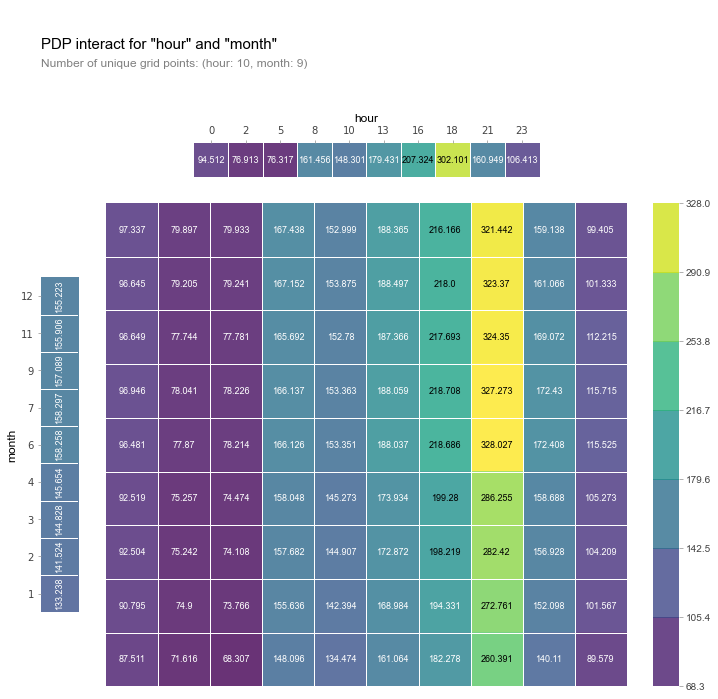

In [69]:
#interactions2
pipe_inter = pdp.pdp_interact(
    model=pipe, dataset=X_train, model_features=X_train.columns, 
    features=['hour', 'month']
)


fig, axes = pdp.pdp_interact_plot(
    pipe_inter, ['hour', 'month'], x_quantile=True, plot_type='grid', plot_pdp=True
)
#conclusion: the hourly pattern is similar regardless of the month